# Paddle Ball with Reinforcement Learning

In [1]:
# Load Packages
import scipy
import matplotlib.pyplot
import numpy
import math
import malbrid
import random

In [2]:
# Store Energy change and detect "too bumpy rides"
class BumpyRideException(Exception):
    pass

bumpEnergy = 0.0
nofBumps = 0
def addBumpEnergy(a):
    global bumpEnergy
    global nofBumps
    nofBumps += 1
    if nofBumps>100:
        raise BumpyRideException()
    bumpEnergy += a
def square(x): # Not actually square. More like "the higher, the better"
    return x*x+abs(x)



def get_dynamics_and_zero_crossing_functions_controller(state_name):
    ATimeCount = numpy.array([[0,0,1]]) 

    x = simulator.get_var("x")
    t = simulator.get_var("t")
    # CS also used

    def nobumpUp(x):
        return "Go",numpy.array([x[0],0,x[2]]),False
    def nobumpDown(x):
        return "End",numpy.array([x[0],0,x[2]]),False
    def nobumpStill(x):
        return "Wait",numpy.array([x[0],0,x[2]]),False

    if state_name=="Active":
        zero_crossing_end_up = t>=0.0
        return ATimeCount, [(zero_crossing_end_up, "GoUp",nobumpUp)]
    if state_name=="Wait":
        return ATimeCount, []
    if state_name=="Go":
        zero_crossing_end_up = t>=0.25
        return ATimeCount, [(zero_crossing_end_up, "GoDown", nobumpDown)]
    if state_name=="End":
        zero_crossing_end_up = t>=0.25
        return ATimeCount, [(zero_crossing_end_up, "GoStill", nobumpStill)]
    else:
        raise Exception("Internal Test error:"+str(state_name))


def get_dynamics_and_zero_crossing_functions_system(state_name):
    # Dynamics matrices
    APaddleDown = numpy.array([[0, 1, 0, 0], [0, 0, 0 ,-9.81], [0, 0, 0, -1], [0, 0, 0, 0 ]],dtype=numpy.float64)
    APaddleUp = numpy.array([[0, 1, 0, 0], [0, 0, 0 , -9.81], [0, 0, 0, 1], [0, 0, 0, 0 ]],dtype=numpy.float64)
    APaddleStill = numpy.array([[0, 1, 0, 0], [0, 0, 0 ,-9.81], [0, 0, 0, 0],[0, 0, 0, 0 ]],dtype=numpy.float64)

    x = simulator.get_var("x")
    xs = simulator.get_var("xspeed")
    p = simulator.get_var("p")
    # CS also defined

    def bumpPaddleUp(x):
        # addBumpEnergy( square(-0.9*x[1]+0.9) )
        addBumpEnergy( 100) 
        return "PaddleUp",numpy.array([x[0],-0.9*x[1]+0.9,x[2],x[3]]),False
    def bumpPaddleDown(x):
        addBumpEnergy( -100 )
        return "PaddleDown",numpy.array([x[0],-0.9*x[1]-0.9,x[2],x[3]]),False
    def bumpPaddleStill(x):
        addBumpEnergy( 0 )
        # addBumpEnergy( square(-0.9*x[1]) )
        return "PaddleStill",numpy.array([x[0],-0.9*x[1],x[2],x[3]]),False
    def nobumpPaddleToUp(x):
        return "PaddleUp",numpy.array([x[0],x[1],x[2],x[3]]),False
    def nobumpPaddleToDown(x):
        return "PaddleDown",numpy.array([x[0],x[1],x[2],x[3]]),False
    def nobumpPaddleToStill(x):
        return "PaddleStill",numpy.array([x[0],x[1],x[2],x[3]]),False

    if state_name=="PaddleUp":
        zero_crossing_end_up = simulator.get_true_condition()
        zero_crossing_bump = (x<=p) & (xs<1)
        return APaddleUp, [(zero_crossing_end_up, "GoDown", nobumpPaddleToDown),(zero_crossing_bump, "bump", bumpPaddleUp)]
    if state_name=="PaddleDown":
        zero_crossing_end_up = simulator.get_true_condition()
        zero_crossing_bump = (x<=p) & (xs<-1)
        return APaddleDown, [(zero_crossing_end_up, "GoStill", nobumpPaddleToStill),(zero_crossing_bump, "bump", bumpPaddleDown)]
    if state_name=="PaddleStill":
        zero_crossing_end_up = simulator.get_true_condition()
        zero_crossing_bump = (x<=p) & (xs<0)
        return APaddleStill, [(zero_crossing_end_up, "GoUp", nobumpPaddleToUp),(zero_crossing_bump, "bump", bumpPaddleStill)]
    else:
        raise Exception("Internal Test error B:"+str(state_name))

'''A test case for the bouncing ball -- Product state case'''
simulator = malbrid.LinearSystemSimulator(["x", "xspeed", "p", "t", "const"])

product_dynamics = malbrid.compute_product_dynamics(
    [("x",1,[0,1]),("xspeed",1,[1]), 
     ("p",1,[1]),("t",0,[0]),("const",1,[0,1])],
    get_dynamics_and_zero_crossing_functions_controller,
    get_dynamics_and_zero_crossing_functions_system,["GoUp","GoDown","GoStill"])


# print(malbrid.to_graphviz(["x", "xspeed", "p", "t", "const"],product_dynamics,("Wait","PaddleStill")))

In [3]:
# Define the Reinforcement learner
ALPHA = 0.1
GAMMA = 0.98

class Learner:
    
    def __init__(self):
        self.Q = {}
    def getChoice(self,state):
        if not state in self.Q:
            self.Q[state] = [0.0,0.0]
        if random.random()>1.0-EPSILON:
            action = random.random()>0.5
            return action
        else:
            qValues = self.Q[state]
            return qValues[1]>qValues[0]
    def reportReward(self,state,action,reward,nextState):
        actionIndex = 0
        if action:
            actionIndex = 1
        if not nextState in self.Q:
            self.Q[nextState] = [0.0,0.0]
        self.Q[state][actionIndex] += ALPHA*(reward + GAMMA*max(self.Q[nextState]) - self.Q[state][actionIndex])
        # print("Reported reward: ",state,action,reward)
        

learner = Learner() 

In [4]:
# Run with Reinforcement learner
# Visualize Q-Funktion and last episode along the way.
%matplotlib inline
from IPython.display import clear_output
NOF_EPISODES = 20

def run_episode():
    global bumpEnergy, nofBumps
    cont_states = [(10.0,0,0,0,1.0)]
    disc_states = [("Wait","PaddleStill")]
    times = [0.0]
    lastState = None
    sumPayoff = 0.0
    nofPayoffs = 0
    for round in range(700):
        last_time = times[-1]
        try:
            simulator.simulate(product_dynamics,disc_states[-1],numpy.array(cont_states[-1]),
                                   max_time=0.05)
        except BumpyRideException:
            # Ride too bumpy. Negative payoff
            bumpEnergy = -1000
            learner.reportReward(lastState,lastAction,bumpEnergy,nextState)
            break
            
        for a in simulator.time_points:
            times.append(a+last_time)
        for a in simulator.continuous_states:
            cont_states.append(a)
        for a in simulator.discrete_states:
            disc_states.append(a)

        # Run learner
        currentPos = cont_states[-1][0]
        currentSpeed = cont_states[-1][1]
        nextState = (int(currentPos),int(currentSpeed))
            
        # Check if BumpEnergy is added
        # Energy too low? Abort, define small reward
        if square(cont_states[-1][0])+square(cont_states[-1][1])<0.1:
            bumpEnergy = -1000
            learner.reportReward(lastState,lastAction,bumpEnergy,nextState)
            sumPayoff += bumpEnergy
            nofPayoffs += 1
            break

        # Actions
        if disc_states[-1][0]=="Wait":

            # Normal reward
            if not lastState is None:
                learner.reportReward(lastState,lastAction,bumpEnergy,nextState)
                sumPayoff += bumpEnergy
                nofPayoffs += 1
                bumpEnergy = 0
                nofBumps = 0
            
            # print("Action choice: ",nextState)
            lastAction = learner.getChoice(nextState)
            # print("L",lastAction)
            lastState = nextState
            
            # Jump?
            if lastAction:
                # Jump!
                disc_states.append(("Active",disc_states[-1][1]))
                cont_states.append(cont_states[-1])
                times.append(times[-1])
                bumpEnergy += -1 # Bump costs a bit
                
    # Plot last execution of the system 
    clear_output(wait=True)
    
    # plot heatmap
    X_MIN = -5
    X_MAX = 5
    Y_MIN = 0
    Y_MAX = 10

    qVisFalse = numpy.zeros([X_MAX-X_MIN+1,Y_MAX-Y_MIN+1])
    qVisTrue = numpy.zeros([X_MAX-X_MIN+1,Y_MAX-Y_MIN+1])
    for x in range(X_MIN,X_MAX+1):
        for y in range(Y_MIN,Y_MAX+1):
            if (y,x) in learner.Q:
                qVisFalse[x-X_MIN,y-Y_MIN] = learner.Q[(y,x)][0]
                qVisTrue[x-X_MIN,y-Y_MIN] = learner.Q[(y,x)][1]

    fig, ax = matplotlib.pyplot.subplots(3,figsize=(10, 19))
    im = ax[0].imshow(qVisFalse)
    im = ax[1].imshow(qVisTrue)

    # Annotate and flip y axis
    for p in [0,1]:
        ax[p].set_xticks(numpy.arange(0,X_MAX-X_MIN+1),numpy.arange(X_MIN,X_MAX+1))
        ax[p].set_yticks(numpy.arange(0,Y_MAX-Y_MIN+1),numpy.arange(Y_MIN,Y_MAX+1))
        ax[p].invert_yaxis()

    # Anotate with text
    for x in range(X_MIN,X_MAX+1):
        for y in range(Y_MIN,Y_MAX+1):
            if (y,x) in learner.Q:
                text = ax[0].text(y-Y_MIN, x-X_MIN, int(qVisFalse[x-X_MIN, y-Y_MIN]), ha="center", va="center", color="w")
                text = ax[1].text(y-Y_MIN, x-X_MIN, int(qVisTrue[x-X_MIN, y-Y_MIN]), ha="center", va="center", color="w")


    # Show Last execution
    fig.tight_layout()
    ax[2].plot(numpy.array(times)[:],numpy.array(cont_states)[:,0])
    ax[2].plot(numpy.array(times)[:],numpy.array(cont_states)[:,2])
    ax[2].set(xlabel='Time in Episode '+str(episode)+" with avg. payoff: "+str(sumPayoff/nofPayoffs))
    ax[2].set(ylabel='Height')
    matplotlib.pyplot.show()


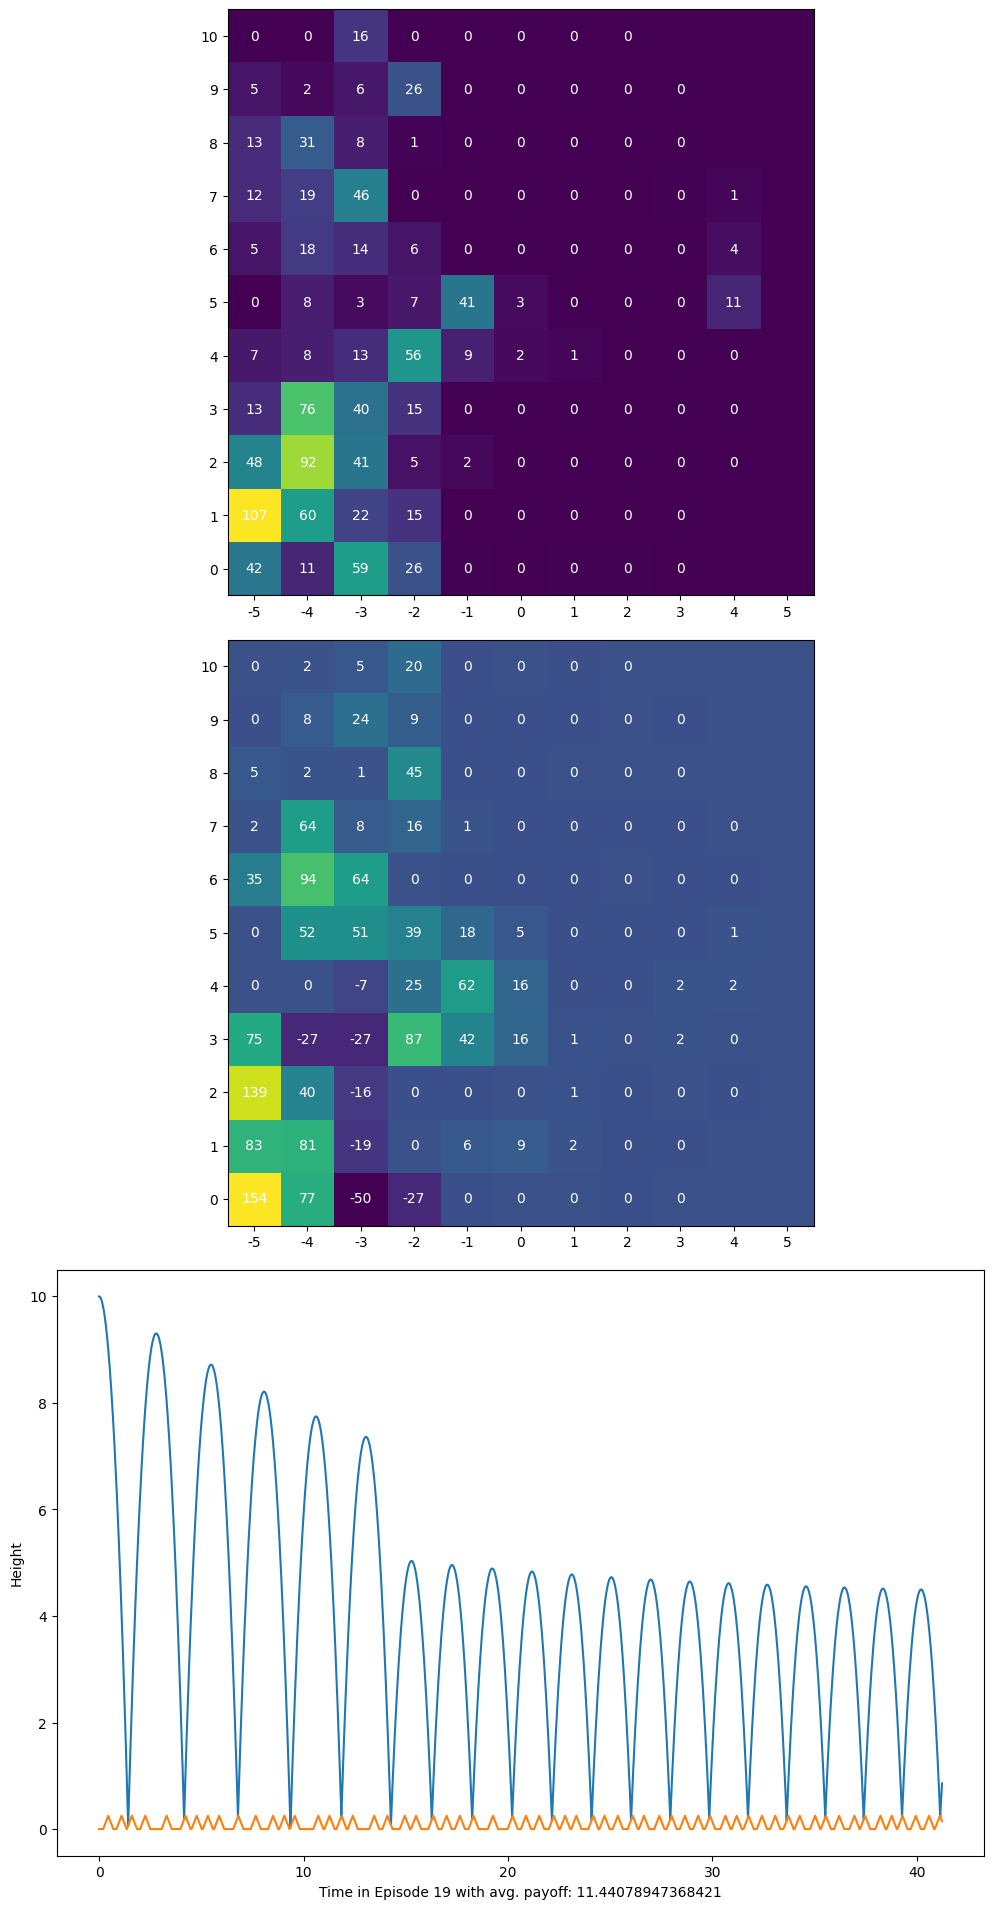

In [5]:
# Learn
EPSILON = 0.3
for episode in range(0,NOF_EPISODES):
    run_episode()


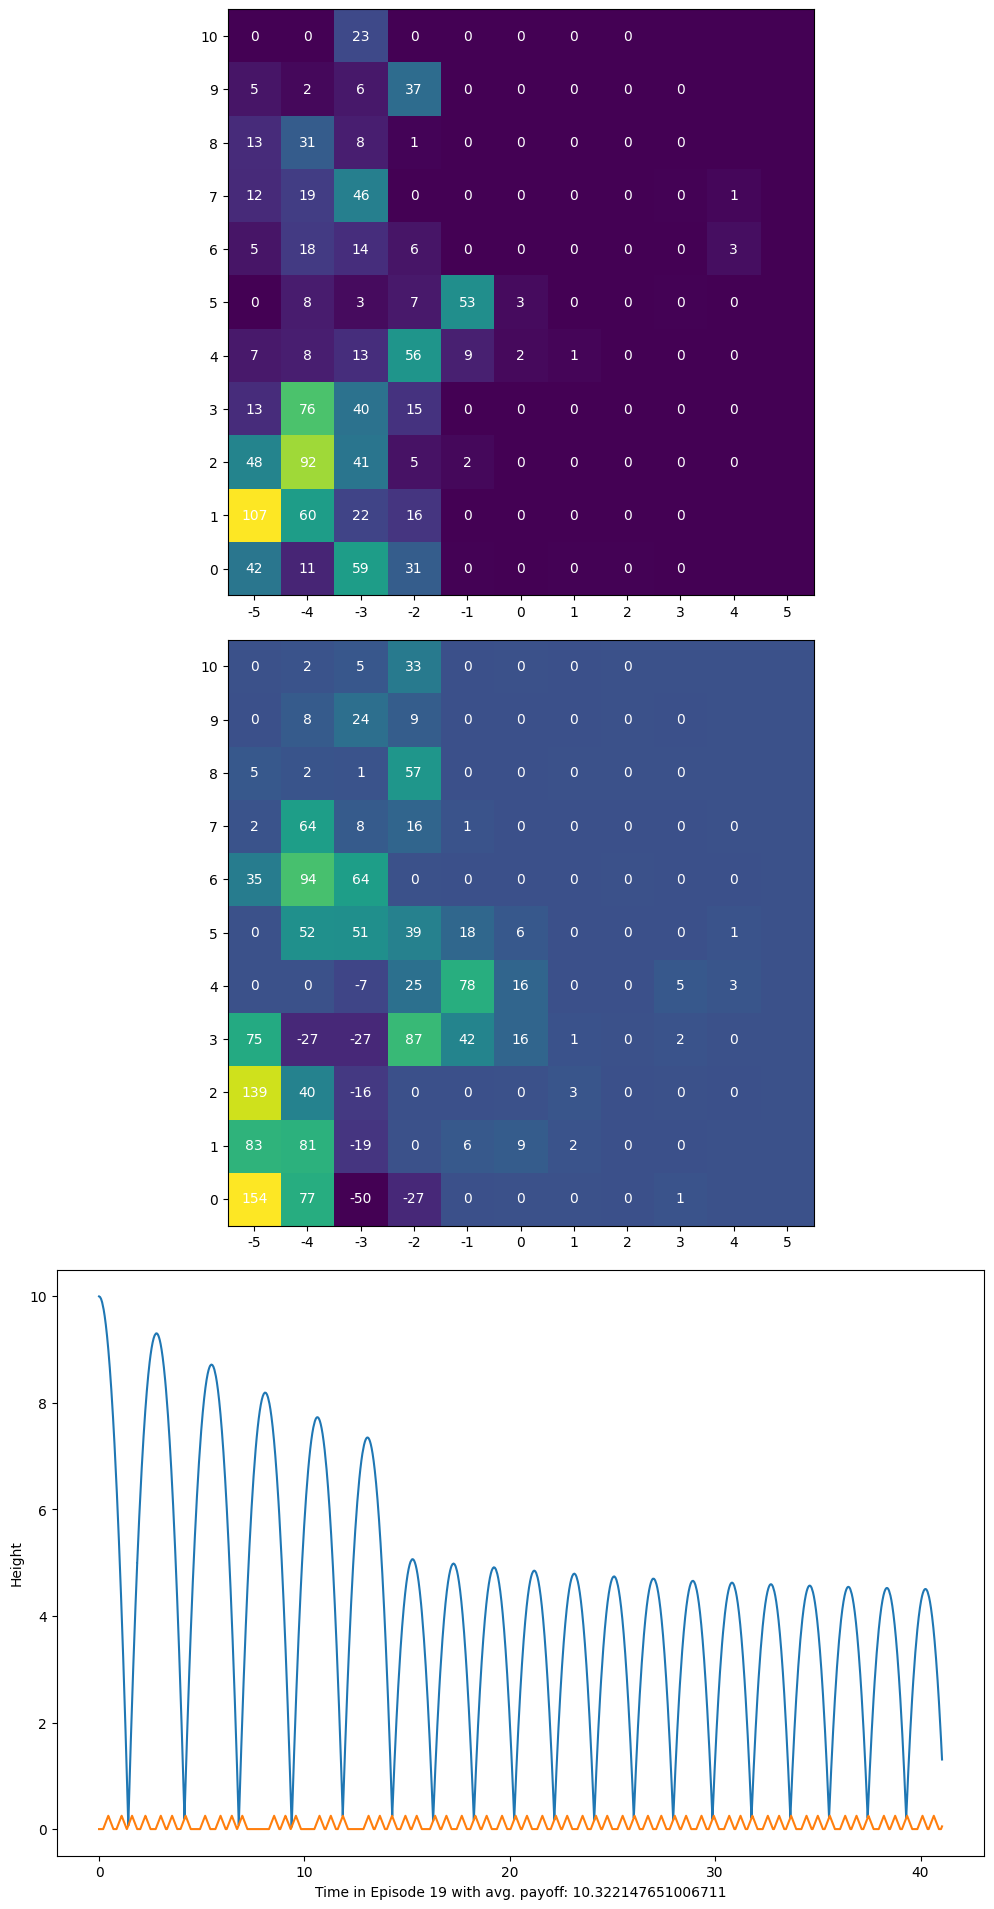

In [6]:
# Exploit
EPSILON = 0.0
run_episode()